---
## Import packages

In [ ]:
a = []
while (1):
 a.append(1)

In [13]:
from art import*
art= text2art ("Let 's     Go    !!!")
print(art)

 _            _     _             ____             _  _  _ 
| |      ___ | |_  ( ) ___       / ___|  ___      | || || |
| |     / _ \| __| |/ / __|     | |  _  / _ \     | || || |
| |___ |  __/| |_     \__ \     | |_| || (_) |    |_||_||_|
|_____| \___| \__|    |___/      \____| \___/     (_)(_)(_)
                                                           



In [1]:
#  pip install art 
# !pip install farasapy
# !pip install Tashaphyne==0.3.4.1
# !pip install wordcloud
# !pip install ar_wordcloud
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')

In [1]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
import matplotlib.pyplot as plt

import string

import re

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report

from ar_wordcloud import ArabicWordCloud

In [2]:
from tashaphyne.stemming import ArabicLightStemmer

In [3]:
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer

In [4]:
from farasa.pos import FarasaPOSTagger
from farasa.ner import FarasaNamedEntityRecognizer
from farasa.diacratizer import FarasaDiacritizer
from farasa.segmenter import FarasaSegmenter
from farasa.stemmer import FarasaStemmer

---
## Read and exploring the data

In [5]:
df = pd.read_csv('SaudiNews')
df.drop(columns= ['Unnamed: 0'], inplace= True)
df

,source,title,content
0,aleqtisadiya,هيئة المسح الجيولوجي الأمريكية: زلزال بقوة 6.3...,قالت هيئة المسح الجيولوجي الأمريكيةإن زلزالا ...
1,alweeam,توفر وظائف أكاديمية بجامعــة الملك فيصل,أعلنت جامعة الملك فيصل بالأحساء توفر عدد من ا...
2,sabq,&quot;أدبي جدة&quot; يدشن دورة &quot;مفاهيم كت...,سبق- جدة: دشَّن أدبي جدة اللقاء الأول من دورة...
3,alyaum,قتلة الطموح,«في مجتمعنا مبدأ يمنع تطور الفرد فكرياً واجتم...
4,alriyadh,دراسة مسببات عدم انخفاض السلع في المملكة بانخف...,أكد الدكتور سليمان السماحي الرئيس التنفيذي...
...,...,...,...
9995,okaz,تطويق العنف المدرسي ببرنامج «رفق» الإرشادي,تعتزم وزارة التعليم، في مستهل العام الدراسي ا...
9996,aawsat,ولي ولي العهد السعودي يتقبل بيعة منسوبي وزارة...,استقبل الأمير محمد بن سلمان بن عبد العزيز ولي ...
9997,alriyadh,هبوط أول طائرة عسكرية سعودية في مطار عدن بعد د...,هبطت طائرة عسكرية سعودية في مطار مدينة عدن...
9998,alwatan,"استثمار ""الربيعة"" عالميا",هناك دول في العالم تنفق مع شركات علاقات عالمي...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   source   10000 non-null  object
 1   title    9978 non-null   object
 2   content  9964 non-null   object
dtypes: object(3)
memory usage: 234.5+ KB


In [7]:
df.duplicated().sum()

94

In [8]:
df.drop_duplicates(inplace = True)

---
## NLP Preprocessing

In [9]:
max(df.content.str.len())

26852.0

In [10]:
min(df.content.str.len())

1.0

**removing observtions less than 120**

In [11]:
df = df[df.content.str.len() > 120]

In [12]:
df.shape

(9716, 3)

In [13]:
df.content.isna().sum()

0

### **Removing Non-arabic letters, numbers, amiss typo and special characters**

In [14]:
# function to clean and normalize text 
def clean_text(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ']  
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel,"", text)
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
        
    text = text.strip()
    
    return text

In [15]:
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)


def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    
    return text


def remove_diacritics(text):
    text = re.sub(arabic_diacritics, '', text)
    return text


def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)


def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [16]:
# clean and normalize text
df['content'] = df.content.apply(lambda x: clean_text(x))

# remove punctuation
df['content'] = df.content.apply(lambda x: remove_punctuations(x))

# remove diacritics
df['content'] = df.content.apply(lambda x: remove_diacritics(x))

# remove repeating char
df['content'] = df.content.apply(lambda x: remove_repeating_char(x))

# remove english letters
df.content = df.content.apply(lambda x: re.sub(r'[a-zA-Z]', '', x))

# remove a special character _
df.content = df.content.apply(lambda x: re.sub(r'[_]+', '', x))

# remove space
df['content'] = df.content.str.replace('\d+', '')

In [17]:
df

,source,title,content
0,aleqtisadiya,هيئة المسح الجيولوجي الأمريكية: زلزال بقوة 6.3...,قالت هيئه المسح الجيولوجي الامريكيهان زلزالا ب...
1,alweeam,توفر وظائف أكاديمية بجامعــة الملك فيصل,اعلنت جامعه الملك فيصل بالاحساء توفر عد من الو...
2,sabq,&quot;أدبي جدة&quot; يدشن دورة &quot;مفاهيم كت...,سبق جده دشن ادبي جده القاء الاول من دوره مفاهي...
3,alyaum,قتلة الطموح,«في مجتمعنا مبدا يمنع تطور الفرد فكريا واجتماع...
4,alriyadh,دراسة مسببات عدم انخفاض السلع في المملكة بانخف...,اكد الدكتور سليمان السماحي الرئيس التنفيذي لجم...
...,...,...,...
9995,okaz,تطويق العنف المدرسي ببرنامج «رفق» الإرشادي,تعتزم وزاره التعليم في مستهل العام الدراسي الم...
9996,aawsat,ولي ولي العهد السعودي يتقبل بيعة منسوبي وزارة...,استقبل الامير محمد بن سلمان بن عبد العزيز ولي ...
9997,alriyadh,هبوط أول طائرة عسكرية سعودية في مطار عدن بعد د...,هبطت طائره عسكريه سعوديه في مطار مدينه عدن جنو...
9998,alwatan,"استثمار ""الربيعة"" عالميا",هناك دول في العالم تنفق مع شركات علاقات عالميه...


In [18]:
# Convert to list
data = df[df.columns[2]].values.tolist()

### **Stemming**

In [20]:
farasa_st = FarasaStemmer()

100%|██████████| 241M/241M [00:19<00:00, 12.2MiB/s]


In [22]:
# st = ISRIStemmer()
# ArListem = ArabicLightStemmer()

# def stemSentence(sentence):
#     token_words=word_tokenize(sentence)
#     stem_sentence=[]
#     for word in token_words:
#         stem_sentence.append(farasa_st.stem(word))
#         #stem_sentence.append(ArListem.light_stem(word))
#         stem_sentence.append(' ')
#     return "".join(stem_sentence)

# df.content = df.content.apply(lambda x: stemSentence(x))

KeyboardInterrupt: ignored

### **TF-IDF Vectorizer**

In [19]:
# the document-term matrix 
arb_stopwords = set(nltk.corpus.stopwords.words('arabic'))
tfidf = TfidfVectorizer(stop_words=arb_stopwords)
doc_words = tfidf.fit_transform(df.content)
pd.DataFrame(doc_words.toarray(),columns=tfidf.get_feature_names())

,ئايه,اؤدي,اؤكد,اؤلئك,اؤمن,اؤيد,اؤيدها,ائتلاف,ائتلافا,ائتلافيه,ائتمان,ائتماني,ائتمانيه,ائتمنه,ائتمنهم,ائذن,ائمتهم,ائمه,اب,ابا,اباء,اباءنا,اباءهم,اباؤكن,اباؤنا,اباؤهم,ابائنا,ابائه,ابائهم,ابائي,ابابا,اباتش,اباتشي,اباتو,اباحسين,اباحه,اباحي,اباحيا,اباحيه,اباد,...,ﻭﺍﻛﻤﻞ,ﻭﺍﻟﺒﺴﺎﺗﻴﻦ,ﻭﺍﻟﺪﺗﻪ,ﻭﺍﻟﻜﺜﻴﺮ,ﻭﺍﻟﻤﺤﺎﻓﻈﺎﺕ,ﻭﺍﻟﻤﺸروعات,ﻭﺍﻟﻤﻠﻔﺎﺕ,ﻭﺍﻟﻤﻮﺍﻧﺊ,ﻭﺍﻹﺳﻼﻣﻲ,ﻭﺑﻌﺪ,ﻭﺗﺤﺘﻮﻱ,ﻭﺗﻘﻴﻢ,ﻭﺟﻤﺎﻋﺔ,ﻭﺣﺪﺓ,ﻭﺣﺸﻴﺔ,ﻭﺩﻟﻴﻞ,ﻭﺭﺋﻴﺲ,ﻭﺯﻳري,ﻭﻗﺪ,ﻭﻛﺎﻥ,ﻭﻛﺎﻧﺖ,ﻭﻣﺴﺘﻘﺮﺓ,ﻭﻣﺴﻤﻊ,ﻭﻣﻌﺎﺭﻙ,ﻭﻣﻦ,ﻭﻫﻤﺎ,ﻭﻫﻤﺠﻴﺔ,ﻳﺤﺘﻮﻱ,ﻳﻮﻡ,ﻷداء,ﻷلات,ﻷن,ﻷنظمه,ﻷهالي,ﻷي,ﻷﺳﺮ,ﻹستقرار,ﻹكمال,ﻹنشائه,ﻻستئصال
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9712,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# # To display full text
# pd.set_option('display.max_colwidth',-1)#can see the whole data on one single row
# complaints_df

## EDA

In [ ]:
# print WordCloud visualization

awc = ArabicWordCloud(background_color="black",)

mpl.rcParams['figure.figsize']=(20,12.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 

# wordcloud = awc.generate(str(tfidf.get_feature_names())).from_text(
#     str(tfidf.get_feature_names()))

wordcloud = awc.generate(str(tfidf.get_feature_names())).from_text(str(tfidf.get_feature_names()))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(colormap='Dark2'),interpolation='bilinear')
#plt.title("Word Cloud of all the words")
plt.axis('off')

count of source

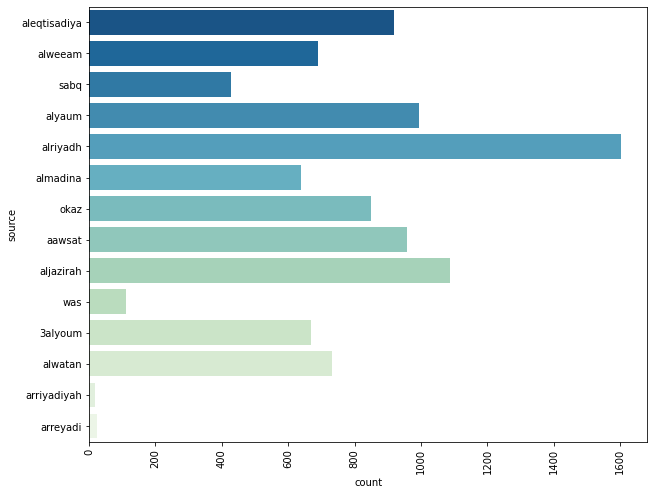

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.xticks(rotation=90)
sns.countplot(y="source", data=df, palette='GnBu_r');

source Distribution

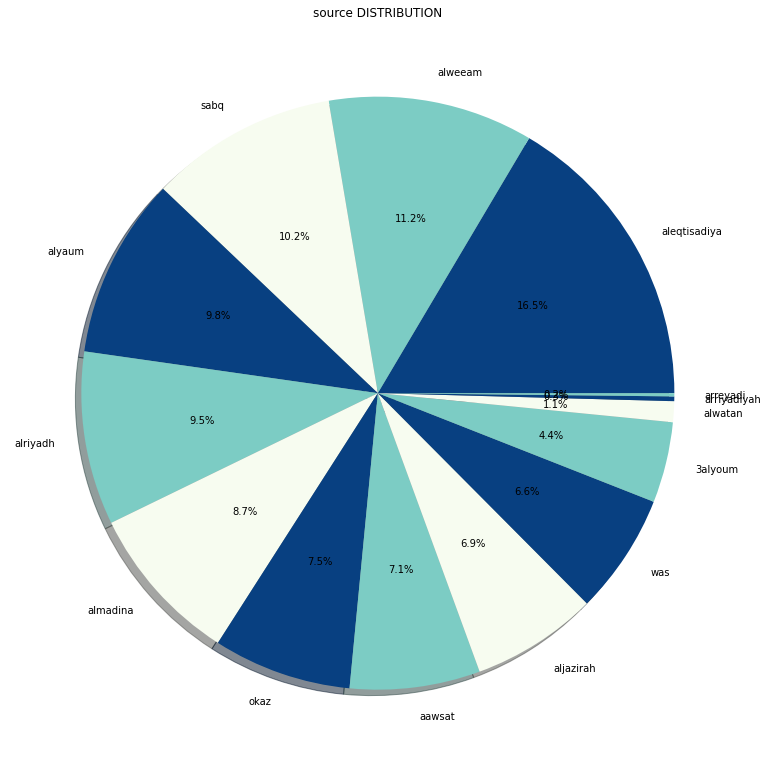

In [33]:
from matplotlib.gridspec import GridSpec
import numpy as np

targetCounts = df['source'].value_counts()
targetLabels  = df['source'].unique()
# Make square figures and axes
plt.figure(1, figsize=(30,30))
the_grid = GridSpec(2, 2)

#Blues_r #PuBuGn #Sequential
cmap = plt.get_cmap('GnBu_r')
colors = [cmap(i) for i in np.linspace(0, 1, 3)]
plt.subplot(the_grid[0, 1], aspect=1, title='source DISTRIBUTION')

source_pie = plt.pie(targetCounts, labels=targetLabels, autopct='%1.1f%%', shadow=True, colors=colors)